In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor
np.random.seed(2023)

# 稳健线性回归

本节讨论离群值对线性回顾的影响. 离群值指的是与大多数样本有较大偏离的小部分样本, 在分布上与大多数样本不一致, 通常认为是在数据获取阶段, 由测量误差引起的, 有时差别会达到几个数量级. 与离群值(outlier)相对的大多数样本被称为inlier, 暂时没有一个好的翻译, 姑且称之为群内值.

离群值会对简单线性回归造成影响, 且影响范围与离群值的离群程度有关. 在下面的示例中, 5个离群值(黄色点)较大地影响了线性回归的系数, 实线代表真实模型, 虚线代表离群值影响下的模型.

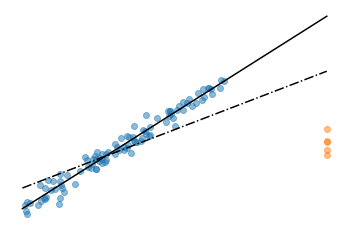

coef_ of regression of inliers: 1.014
coef_ of regression of all samples: 0.615


In [3]:
X = 20 * np.random.rand(100)
y = 1 * X + np.random.normal(scale=1, size=(100,))
outX = np.repeat(30, 5)
outy = np.random.normal(loc=10, scale=1, size=(5,))
x_space = np.array([0, 30])

lr_all = LinearRegression().fit(np.hstack((X, outX)).reshape(-1, 1), np.hstack((y, outy)))
lr_inlier = LinearRegression().fit(X.reshape(-1, 1), y)

plt.figure(1)
ax = plt.gca()
ax.axis('off')
ax.scatter(X, y, c='C0', alpha=0.5)
ax.plot(x_space, lr_inlier.predict(x_space.reshape(-1, 1)), c='black')
ax.scatter(outX, outy, c='C1', alpha=0.5)
ax.plot(x_space, lr_all.predict(x_space.reshape(-1, 1)), c='black', linestyle='-.')
plt.show()

print('coef_ of regression of inliers: {:.3f}'.format(lr_inlier.coef_[0]))
print('coef_ of regression of all samples: {:.3f}'.format(lr_all.coef_[0]))

本节介绍一些方法克服离群值对线性回归模型的影响.

## RANSAC

RANSAC采用迭代随机抽样方法, 从数据中确定群内值和离群值, 再用所有群内值作简单线性回归. `RANSACRegressor`类提供了此方法, 具体操作步骤[(1)](https://scikit-learn.org/stable/modules/linear_model.html#ransac-random-sample-consensus)为, 在每一次迭代中执行下面的四个步骤:

1. 选择若干随机样本, 可用`min_samples`参数控制样本数量. 抽出的样本集合如有需要, 可以用`is_data_valid`参数传入一个函数检测有效性.
2. 根据随机子集拟合线性回归模型. 如有需要, 可以由`is_model_valid`参数传入一个函数检测模型有效性.
3. 根据此模型将所有数据点分为群内值和离群值, 方法是计算样本点残差与参数`residual_threshold`对比, 残差大于此值的样本点被视为离群值. 默认情况下, `residual_threshold`取标签`y`的绝对偏差中位数.
4. 模型的好坏由分出的群内点数量决定, 如果两个模型分出的群内点一样多, 则更高的 $R^2$ 对应的模型更好.

上述参数中, `min_samples`可以是浮点数表示占总训练集的比例, 迭代的次数可由下面的任一参数控制:

- `max_trials`: 迭代的最大次数.
- `stop_n_inliers`: 如果找到此数量的群内点, 就停止迭代.
- `stop_score`: 如果模型分数大于此值, 就停止迭代.

注意到, 这是一个随机模型, 因此含有`random_state`参数以设置一个随机状态. 更多模型参数可在[(2)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html)处找到. 另外, 拟合后的模型内点可以用`inlier_mask_`属性查看.

下面用RANSAC对上面的数据进行拟合, 并找出群内点.

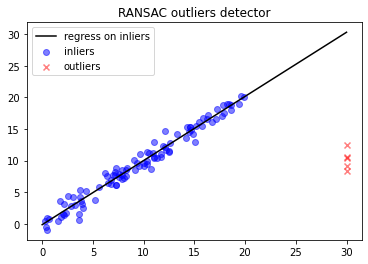

In [4]:
X_all = np.hstack((X, outX)); y_all = np.hstack((y, outy))

ransac = RANSACRegressor(
    max_trials = 1000,
    random_state = 2023
).fit(X_all.reshape(-1, 1), y_all)

x_space = np.array([0, 30])

plt.figure(1)
ax = plt.gca()
ax.set_title('RANSAC outliers detector')
ax.plot(x_space, ransac.predict(x_space.reshape(-1, 1)), c='black', label='regress on inliers')
ax.scatter(X_all[ransac.inlier_mask_], y_all[ransac.inlier_mask_], alpha=0.5, c='blue', marker='o', label='inliers')
ax.scatter(X_all[~ransac.inlier_mask_], y_all[~ransac.inlier_mask_], alpha=0.5, c='red', marker='x', label='outliers')
ax.legend()
plt.show()

RANSAC找到了所有的离群值, 也错误地将一个群内值标记为离群值. 

```{admonition} 注意

RANSAC中默认的模型为线性回归, 但它也接受其他模型的离群值检测, 可以通过`estimator`参数传入一个回归器实例.

```

## Huber回归

RANSAC基于随机尝试, 拟合一系列模型, 并定义离群值, 从所有模型中选择离群值最少的那个. Huber回归则是一种确定性方法, 它不忽视数据中的离群值, 而是赋予更小的权重.

一般线性回归使用最小二乘法, 如果模型对样本 $X_i$ 的预测值是 $\hat y_i$, 那么最小化的目标(即损失函数)是

$$
J_\text{OLS}=\sum_{i=1}^{n}(y_i-\hat y_i)^2:=\sum_{i=1}^{n}l(y_i,\hat y_i),
$$

这里使用 $l(y_i, \hat y_i)$ 表示两个值之间的差异, 将这样的函数 $l$ 称为损失, 不同的损失对模型有不同的影响. 要减轻离群值的影响, 就要使得 $y_i$ 和 $\hat y_i$ 差距大的样本对模型的影响较少. Huber损失指定了一个阈值 $\varepsilon$, 当 $|y_i-\hat y_i|$ 较大时使用绝对值损失, 较小时使用二次损失, 这样在保证损失函数可微性的同时减小了离群值的影响. 下面是Huber回归的损失函数[(2)](https://scikit-learn.org/stable/modules/linear_model.html#huber-regression):

$$
J_\text{Huber}=\sum_{i=1}^{n}\left(\sigma+H_\epsilon\left(\frac{y_i-X_iw}{\sigma} \right)\sigma \right)+\alpha\|w\|_2^2,
$$

这里, $H_\epsilon$即Huber损失, 依赖于参数 $\epsilon$, 表达式为

$$
H_\epsilon(z)=\begin{cases}
z^2, & |z|<\epsilon; \\
2\epsilon|z| - \epsilon^2,& |z|\ge \epsilon;
\end{cases}
$$

在 $|z|=\epsilon$ 处 $H'_\epsilon(z)=2\epsilon \mathrm{sign}(z)$. 另外, 参数 $\sigma$ 是尺度参数, 不需要预先指定, 它保证回归目标 $y$ 按照比例放缩后, 不需要对应地缩放 $\epsilon$.

使用`HuberRegressor`创建一个Huber回归实例, 它可以调整以下参数:

- `epsilon`: 调整 $\epsilon$ 的参数, 控制线性损失和二次损失的阈值, 越小的`epsilon`识别离群值的力度越大. 默认值为 $1.35$, 保证离群值 $95\%$ 的统计置信度.
- `alpha`: 调整 $L_2$ 正则的惩罚力度.
- `warm_start`: 设置再次调用`fit`方法时是否复用原先的模型系数.
- `max_iter`: 最大迭代次数.

其中, 后两个参数在大多数基于迭代优化的估计器中都有出现, 以后不再介绍. 拟合模型后, 可以通过`scale_`查看 $\sigma$ 的值, `outliers_`查看被定义为离群值的样本.

下面用`HuberRegressor`拟合上面的数据, 并打印其属性, 查看离群值和回归直线. 可以发现, 尽管模型将许多点定义为离群值, 但回归直线的系数与真实系数相差不大.

sigma: 0.757
coef: 0.970


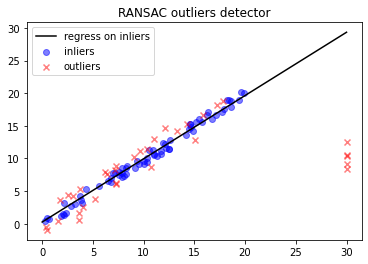

In [12]:
huber = HuberRegressor().fit(X_all.reshape(-1, 1), y_all)
print('sigma: {:.3f}'.format(huber.scale_))
print('coef: {:.3f}'.format(huber.coef_[0]))

plt.figure(1)
ax = plt.gca()
ax.set_title('RANSAC outliers detector')
ax.plot(x_space, huber.predict(x_space.reshape(-1, 1)), c='black', label='regress on inliers')
ax.scatter(X_all[~huber.outliers_], y_all[~huber.outliers_], alpha=0.5, c='blue', marker='o', label='inliers')
ax.scatter(X_all[huber.outliers_], y_all[huber.outliers_], alpha=0.5, c='red', marker='x', label='outliers')
ax.legend()
plt.show()

由于`epsilon`对离群值的辨别很重要, 因此对同一数据集, 不同的`epsilon`会给出不同的结果. `epsilon`越大, 回归结果越接近一般线性回归[(3)](https://scikit-learn.org/stable/auto_examples/linear_model/plot_huber_vs_ridge.html). 下面选择不同的`epsilon`对比回归结果.

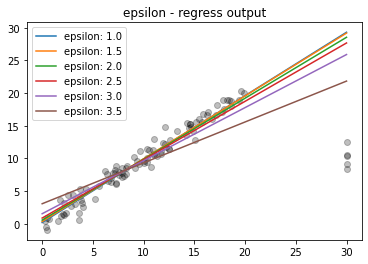

In [23]:
epsilons = np.arange(1, 4, 0.5)

plt.figure(1)
ax = plt.gca()
ax.scatter(X_all, y_all, c='black', alpha=0.25)

for i, epsilon in enumerate(epsilons):
    huber_temp = HuberRegressor(epsilon=epsilon).fit(X_all.reshape(-1, 1), y_all)
    preds = huber_temp.predict(x_space.reshape(-1, 1))
    ax.plot(x_space, preds, label=f'epsilon: {epsilon}', c=f'C{i}')

ax.legend()
ax.set_title('epsilon - regress output')
plt.show()